In [1]:
%matplotlib inline

from __future__ import division
import numpy as np
import nibabel as nb
from scipy import stats, signal
import matplotlib.pylab as plt
import seaborn as sns
from nipype.interfaces import ants, dcm2nii
import time

import os

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


ModuleNotFoundError: No module named 'nipype'

## Myelin map test:

To do - Remove 0 values from mode calculation


**MNI ICMB template**:

mni_icbm152_t1_tal_nlin_sym_09a - T1 template

mni_icbm152_t2_tal_nlin_sym_09a - T2 template


eye_mask - Eye mask from ICMB template

temporal_bone_mask - Temporal bone mask from ICMB template

Test1 participant is TIA1A

Test2 participant is TIA34B

Terrible participant - Massive motion artifact in t1 and t2.

In [2]:
#Load images, get info / data

subj_dir = './test2/'

# #Filenames:
t1_im_subj_fn = os.path.join(subj_dir, 't1', 't1.nii')
t2_im_subj_fn = os.path.join(subj_dir, 't2', 't2.nii')

t1_im_mni_fn = os.path.join('./resources','mni_icbm152_t1_tal_nlin_sym_09a.nii')
t2_im_mni_fn = os.path.join('./resources','mni_icbm152_t2_tal_nlin_sym_09a.nii')

eye_mni_mask_fn = os.path.join('./resources','eye_mask.nii.gz')
temp_mni_mask_fn = os.path.join('./resources','temp_bone_mask.nii.gz')

brain_mask_fn = os.path.join('./resources','mni_icbm152_t1_tal_nlin_sym_09a_mask.nii')

#Load image headers + data
t1_hdr_subj = nb.load(t1_im_subj_fn)
t1_im_subj = t1_hdr_subj.get_data()

t2_hdr_subj = nb.load(t2_im_subj_fn)
t2_im_subj = t2_hdr_subj.get_data()

t1_im_mni = nb.load(t1_im_mni_fn).get_data()
t2_im_mni = nb.load(t2_im_mni_fn).get_data() 

#Load masks
eye_mni_mask = nb.load(eye_mni_mask_fn).get_data().astype(bool)
temp_mni_mask = nb.load(temp_mni_mask_fn).get_data().astype(bool)

#Get shape information
t1_subj_shape = t1_im_subj.shape
t2_subj_shape = t2_im_subj.shape

#Get image centers
t1_im_center = [int(c / 2) if n < 2 else int((c / 2 )+ (c * .10)) for n, c in enumerate(t1_subj_shape)]
t2_im_center = [int(c / 2) if n < 2 else int((c / 2 )+ (c * .10)) for n, c in enumerate(t2_subj_shape)]

In [3]:
#Get modes of MNI tempates using scipy.stats.mode

t1_mni_eye = stats.mode(t1_im_mni[eye_mni_mask])[0][0]
t1_mni_temp = stats.mode(t1_im_mni[temp_mni_mask])[0][0]
t2_mni_eye = stats.mode(t2_im_mni[eye_mni_mask])[0][0]
t2_mni_temp = stats.mode(t2_im_mni[temp_mni_mask])[0][0]

print(t1_mni_temp, t1_mni_eye, t2_mni_temp, t2_mni_eye)

#Values from paper are: 58.6, 28.2, 21.1, 99.9

59.108840237604454 30.293271934846416 20.13698100671172 99.68526552990079


In [ ]:
raw_dir = '/mnt/c/Users/pgoodin/'

In [9]:
scan_dirs = {'t1': 'test_1', 't2': 'test_2'}


dict_values

In [3]:





anat_convert = dcm2nii.Dcm2niix()
anat_convert.inputs.sourcedir = scan_dir


NameError: name 'scan_dir' is not defined

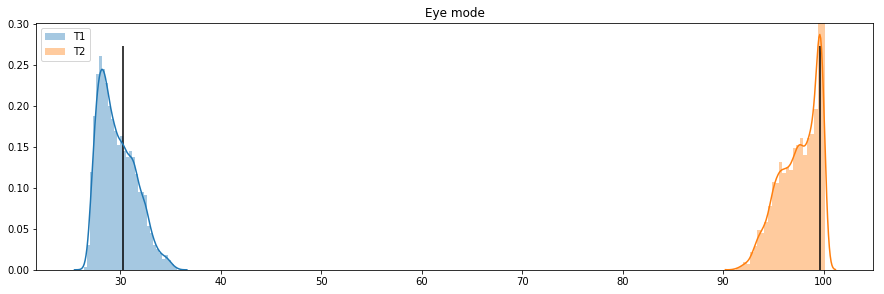

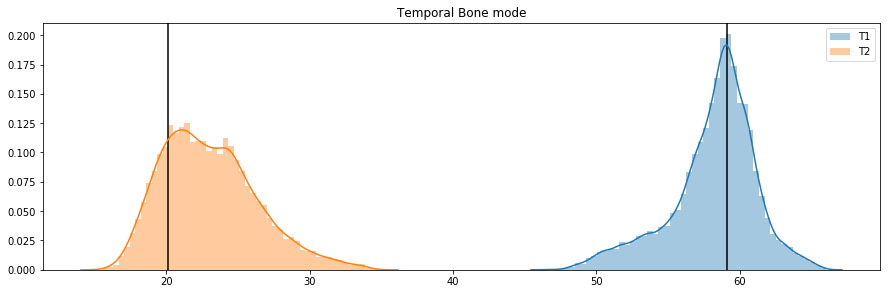

T1 eye: 30.293271934846416
T2 eye: 99.68526552990079
T1 temp: 59.108840237604454
T2 temp: 20.13698100671172


In [31]:
#Plot mask dists

def plot_mask_dist(t1, t2, eye_mask, temp_mask, stat = None):
    
    if stat == 'mean':
        t1_eye_stat = np.mean(t1[eye_mask])
        t1_temp_stat = np.mean(t1[temp_mask])
        t2_eye_stat = np.mean(t2[eye_mask])
        t2_temp_stat = np.mean(t2[temp_mask])
        
    elif stat == 'median':
        t1_eye_stat = np.median(t1[eye_mask])
        t1_temp_stat = np.median(t1[temp_mask])
        t2_eye_stat = np.median(t2[eye_mask])
        t2_temp_stat = np.median(t2[temp_mask])
        
        
    elif stat == 'mode' or stat == None:
        t1_eye_stat = stats.mode(t1[eye_mask][t1[eye_mask] > 0])[0][0]
        t1_temp_stat = stats.mode(t1[temp_mask][t1[temp_mask] > 0])[0][0]
        t2_eye_stat = stats.mode(t2[eye_mask][t2[eye_mask] > 0])[0][0]
        t2_temp_stat = stats.mode(t2[temp_mask][t2[temp_mask] > 0])[0][0]
        
    
    fig = plt.figure(figsize = [15, 10]);
    plt.subplot(2,1,1);
    plt.title('Eye ' + stat)
    sns.distplot(t1[eye_mask], label = 'T1');
    ymin, ymax = fig.gca().axes.get_ybound()
    plt.vlines(x = t1_eye_stat, ymin = ymin, ymax = ymax)
    sns.distplot(t2[eye_mask], label = 'T2');
    plt.vlines(x = t2_eye_stat, ymin = ymin, ymax = ymax)
    plt.legend()
    plt.show()
    
    fig = plt.figure(figsize = [15, 10]);
    plt.subplot(2,1,2);
    plt.title('Temporal Bone ' + stat)
    sns.distplot(t1[temp_mask], label = 'T1');
    ymin, ymax = fig.gca().axes.get_ybound()
    plt.vlines(x = t1_temp_stat, ymin = ymin, ymax = ymax)
    sns.distplot(t2[temp_mask], label = 'T2');
    plt.vlines(x = t2_temp_stat, ymin = ymin, ymax = ymax)
    plt.legend()
    plt.show()
    
    print('T1 eye: {}\nT2 eye: {}\nT1 temp: {}\nT2 temp: {}'.format(t1_eye_stat, t2_eye_stat, t1_temp_stat, t2_temp_stat))

plot_mask_dist(t1_im_mni, t2_im_mni, eye_mni_mask, temp_mni_mask, 'mode')

In [6]:
#Warp MNI to subj space

output_filename = os.path.join(subj_dir, 'output_warped_image.nii.gz')

def ants_reg(fixed = None, moving = None, prefix = None, fixed_mask = None, moving_mask = None, out_image_filename = None):
    
    '''
    Uses ANTs to warp the moving image to the space of the fixed. 
    Both fixed and moving images can have masks.
    
    If warping subjects with lesion damage, it is recommended to warp from MNI to subj space 
    (fixed = subj, moving = mni template, fixed_mask = lesion mask) then
    use the inverse transform to warp from subj to MNI.
    
    '''
    reg = ants.Registration()
    reg.inputs.fixed_image = fixed
    reg.inputs.moving_image = moving

    if fixed_mask != None:
        reg.inputs.fixed_mask = fixed_mask

    if moving_mask != None:
        reg.inputs.moving_mask = fixed_mask

    if prefix != None:
        reg.inputs.output_transform_prefix = prefix
    else:
        reg.inputs.output_transform_prefix = 'out_trans_'
    reg.inputs.transforms = ['Rigid', 'Affine', 'SyN']
    reg.inputs.transform_parameters = [(0.1,),(0.1,),(0.1, 3.0, 0.0)] #Size of movement for registration (Optimal values are 0.1-0.25.)
    reg.inputs.number_of_iterations =[[1000, 500, 250, 100],[1000, 500, 250, 100],[100, 70, 50, 20]]
    reg.inputs.dimension = 3
    # '''
    # Align the moving_image and fixed_image before registration using the geometric
    # center of the images (=0), the image intensities (=1),or the origin of the images (=2)
    # '''
    reg.inputs.initial_moving_transform_com = 0 
    reg.inputs.write_composite_transform = True
    reg.inputs.collapse_output_transforms = False
    reg.inputs.initialize_transforms_per_stage = False
    reg.inputs.metric = ['MI', 'MI', 'CC']
    reg.inputs.radius_or_number_of_bins = [32, 32, 4]
    reg.inputs.sampling_strategy = ['Regular','Regular','None']
    reg.inputs.sampling_percentage = [0.25, 0.25, 1]
    reg.inputs.convergence_threshold = [1e-06]
    reg.inputs.convergence_window_size = [10]
    reg.inputs.smoothing_sigmas = [[3, 2, 1, 0]] * 3
    reg.inputs.sigma_units = ['vox'] * 3
    reg.inputs.shrink_factors = [[8, 4, 2, 1]] * 3
    reg.inputs.use_estimate_learning_rate_once = [True, True, True]
    reg.inputs.use_histogram_matching = True
    if output_filename == None:
        reg.inputs.output_warped_image = 'output_warped_image.nii.gz'
    else:
        reg.inputs.output_warped_image = output_filename + '.nii.gz'
    reg.inputs.num_threads = 8
    reg.inputs.metric_weight = [1.0] * 3
    reg.inputs.winsorize_lower_quantile = 0.005
    reg.inputs.winsorize_upper_quantile = 0.995
    reg.inputs.verbose = True
    res = reg.run()
        
output_filename = 'output_warped_image.nii.gz'
ants_reg(fixed = t1_im_subj_fn, moving = t1_im_mni_fn, out_image_filename = output_filename)

In [7]:
#Check warp quality

def plot_ants_warp(fixed, moving, nslices, output_name = None):
    """
    Plots nslices axial images of the fixed and moving images from the ants transform
    
    inputs:
    anat - Fixed image (image the moving was warped to) 
    moving - Moving image (Transformed image)
    nslices - Number of slices to plot
    output_name - filename to save png image to (optional)
    
    """
    fixed_data = nb.load(fixed).get_data()
    moving_data = nb.load(moving).get_data()
    
    view_slices = np.linspace(100, fixed_data.shape[1] - 1, num = nslices).astype(int)
    
    fig = plt.figure(figsize = [50, 25])

    for n, view_slice in enumerate(view_slices):
        plt.subplot(1, nslices, n + 1)
        plt.imshow(fixed_data[:, :, view_slice], cmap = 'Greys_r')
        plt.imshow(moving_data[:, :, view_slice], cmap = 'Reds', alpha = 0.25)
        plt.axis('off')
        plt.text(1,1, 'z = ' + str(view_slice), color = [1,0,0], bbox=dict(facecolor=[0,0,0]), fontsize = 20)
        plt.tight_layout()
    plt.show()
    
    if output_name != None:
        fig.savefig(fname = output_name + '.png')
        
plot_ants_warp(t1_im_subj_fn, output_filename, 10, os.path.join(subj_dir, 'warp'))

FileNotFoundError: No such file: './test2/output_warped_image.nii.gz'

In [7]:
#Transform eye + temporal mask + brain mask from MNI to subj

def mask_transform(mask_list, ref, transmat):
    '''
    Transforms masks from MNI to subj space
    masks = list of eye + temporal mask images
    transmat = mapping from MNI > subj space
    '''
    
    for mask in mask_list:
    
        image_file = os.path.split(mask)[1]
        image_name = image_file.split('.')[0]
        print(image_name)
        
        mni2subj = ants.ApplyTransforms()
        mni2subj.inputs.input_image = mask
        mni2subj.inputs.reference_image = ref
        mni2subj.inputs.transforms = transmat
        mni2subj.inputs.interpolation = 'NearestNeighbor'
        mni2subj.inputs.output_image = image_name + '_subj.nii.gz'
        mni2subj.run()

        
mask_list = [eye_mni_mask_fn, temp_mni_mask_fn, brain_mask_fn]        
        
mask_transform(mask_list, t1_im_subj_fn, 'out_trans_Composite.h5')

eye_mask
temp_bone_mask
mni_icbm152_t1_tal_nlin_sym_09a_mask


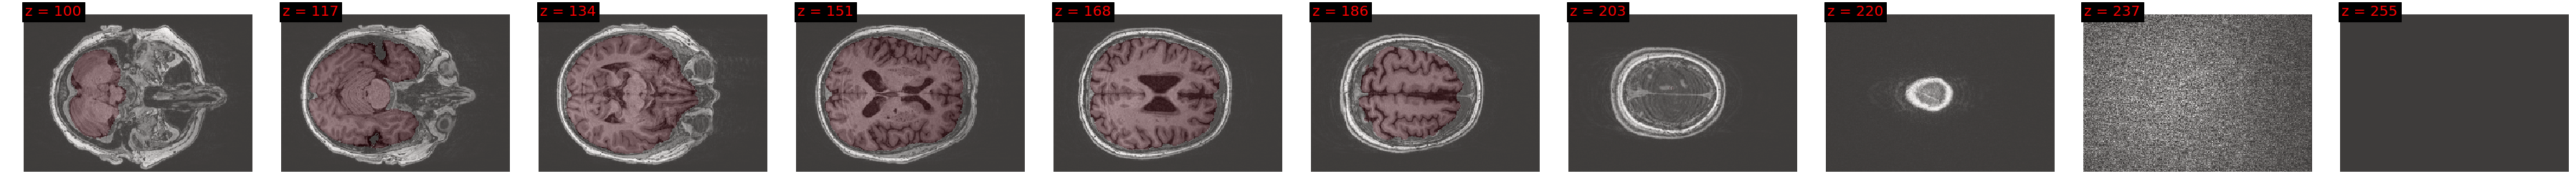

In [11]:
#Check brain extraction output
plot_ants_warp(t1_im_subj_fn, 'mni_icbm152_t1_tal_nlin_sym_09a_mask_subj.nii.gz', 10, 'brain_mask')

In [5]:
#Register T2 to T1
'''
#'Linear' or 'NearestNeighbor' or 'CosineWindowedSinc' or 'WelchWindowedSinc' or 
'HammingWindowedSinc' or 'LanczosWindowedSinc' or 'BSpline' or 'MultiLabel' or 'Gaussian',
'''
trans_prefix = 'rigid_trans_'

reg = ants.Registration()

reg.inputs.fixed_image = t1_im_subj_fn
reg.inputs.moving_image = t2_im_subj_fn
reg.inputs.output_transform_prefix = trans_prefix
reg.inputs.transforms = ['Rigid']
reg.inputs.transform_parameters = [(0.1,)] #Size of movement for registration (Optimal values are 0.1-0.25.)
reg.inputs.number_of_iterations = [[1000, 500, 250, 100]]
reg.inputs.dimension = 3
# 
# Align the moving_image and fixed_image before registration using the geometric
# center of the images (=0), the image intensities (=1),or the origin of the images (=2)
# 
reg.inputs.initial_moving_transform_com = 0 
reg.inputs.write_composite_transform = True
reg.inputs.collapse_output_transforms = False
reg.inputs.initialize_transforms_per_stage = False
reg.inputs.metric = ['MI']
reg.inputs.radius_or_number_of_bins = [32]
reg.inputs.sampling_strategy = ['Regular']
reg.inputs.sampling_percentage = [0.25]
reg.inputs.convergence_threshold = [1e-06]
reg.inputs.convergence_window_size = [10]
reg.inputs.smoothing_sigmas = [[3, 2, 1, 0]]
reg.inputs.sigma_units = ['vox']
reg.inputs.shrink_factors = [[8, 4, 2, 1]]
reg.inputs.use_estimate_learning_rate_once = [True]
reg.inputs.use_histogram_matching = [True]
reg.inputs.output_warped_image = trans_prefix + 't2_image.nii.gz'
reg.inputs.num_threads = 8
reg.inputs.metric_weight = [1.0]
reg.inputs.winsorize_lower_quantile = 0.005
reg.inputs.winsorize_upper_quantile = 0.995
reg.inputs.verbose = True
reg.inputs.interpolation = 'NearestNeighbor' #Started with NN, gave good output.
res = reg.run()

180525-14:29:02,240 interface INFO:
	 stdout 2018-05-25T14:29:02.240761:All_Command_lines_OK
180525-14:29:02,242 interface INFO:
	 stdout 2018-05-25T14:29:02.240761:Using double precision for computations.
180525-14:29:02,522 interface INFO:
	 stdout 2018-05-25T14:29:02.522035:=============================================================================
180525-14:29:02,522 interface INFO:
	 stdout 2018-05-25T14:29:02.522035:The composite transform comprises the following transforms (in order): 
180525-14:29:02,522 interface INFO:
	 stdout 2018-05-25T14:29:02.522035:  1. Image center alignment using fixed image: ./test2/t1/t1.nii and moving image: ./test2/t2/t2.nii (type = Euler3DTransform)
180525-14:29:02,523 interface INFO:
	 stdout 2018-05-25T14:29:02.522035:=============================================================================
180525-14:29:02,544 interface INFO:
	 stdout 2018-05-25T14:29:02.544788:  number of levels = 4
180525-14:29:02,545 interface INFO:
	 stdout 2018-05-25T

180525-14:29:03,26 interface INFO:
	 stdout 2018-05-25T14:29:02.847758:  Reference Count: 2
180525-14:29:03,28 interface INFO:
	 stdout 2018-05-25T14:29:02.847758:  Modified Time: 1591
180525-14:29:03,28 interface INFO:
	 stdout 2018-05-25T14:29:02.847758:  Debug: Off
180525-14:29:03,29 interface INFO:
	 stdout 2018-05-25T14:29:02.847758:  Object Name: 
180525-14:29:03,29 interface INFO:
	 stdout 2018-05-25T14:29:02.847758:  Observers: 
180525-14:29:03,30 interface INFO:
	 stdout 2018-05-25T14:29:02.847758:    none
180525-14:29:03,31 interface INFO:
	 stdout 2018-05-25T14:29:02.847758:  Source: (none)
180525-14:29:03,31 interface INFO:
	 stdout 2018-05-25T14:29:02.847758:  Source output name: (none)
180525-14:29:03,32 interface INFO:
	 stdout 2018-05-25T14:29:02.847758:  Release Data: Off
180525-14:29:03,32 interface INFO:
	 stdout 2018-05-25T14:29:02.847758:  Data Released: False
180525-14:29:03,33 interface INFO:
	 stdout 2018-05-25T14:29:02.847758:  Global Release Data: Off
180525-1

180525-14:29:04,423 interface INFO:
	 stdout 2018-05-25T14:29:04.423317:  Shrink factors (level 1 out of 4): [8, 8, 8]
180525-14:29:04,423 interface INFO:
	 stdout 2018-05-25T14:29:04.423317:  Shrink factors (level 2 out of 4): [4, 4, 4]
180525-14:29:04,424 interface INFO:
	 stdout 2018-05-25T14:29:04.423317:  Shrink factors (level 3 out of 4): [2, 2, 2]
180525-14:29:04,424 interface INFO:
	 stdout 2018-05-25T14:29:04.423317:  Shrink factors (level 4 out of 4): [1, 1, 1]
180525-14:29:04,424 interface INFO:
	 stdout 2018-05-25T14:29:04.423317:  smoothing sigmas per level: [3, 2, 1, 0]
180525-14:29:04,425 interface INFO:
	 stdout 2018-05-25T14:29:04.423317:  regular sampling (percentage = 0.25)
180525-14:29:04,426 interface INFO:
	 stdout 2018-05-25T14:29:04.426290:
180525-14:29:04,426 interface INFO:
	 stdout 2018-05-25T14:29:04.426290:*** Running Euler3DTransform registration ***
180525-14:29:04,430 interface INFO:
	 stdout 2018-05-25T14:29:04.426290:
180525-14:29:07,257 interface INFO

180525-14:29:10,898 interface INFO:
	 stdout 2018-05-25T14:29:10.898616: 2DIAGNOSTIC,    25, -7.546152061804e-01, 6.595227355806e-06, 6.4740e+00, 4.0442e-02, 
180525-14:29:10,961 interface INFO:
	 stdout 2018-05-25T14:29:10.961927: 2DIAGNOSTIC,    26, -7.544367793977e-01, 3.410313717520e-06, 6.5373e+00, 6.3295e-02, 
180525-14:29:11,9 interface INFO:
	 stdout 2018-05-25T14:29:11.009127: 2DIAGNOSTIC,    27, -7.544347741697e-01, 1.152775493805e-06, 6.5845e+00, 4.7196e-02, 
180525-14:29:13,37 interface INFO:
	 stdout 2018-05-25T14:29:13.037728:DIAGNOSTIC,Iteration,metricValue,convergenceValue,ITERATION_TIME_INDEX,SINCE_LAST
180525-14:29:13,39 interface INFO:
	 stdout 2018-05-25T14:29:13.037728: 2DIAGNOSTIC,     1, -7.281250696514e-01, 1.797693134862e+308, 8.6131e+00, 2.0286e+00, 
180525-14:29:13,265 interface INFO:
	 stdout 2018-05-25T14:29:13.265659: 2DIAGNOSTIC,     2, -7.306611740447e-01, 1.797693134862e+308, 8.8410e+00, 2.2789e-01, 
180525-14:29:13,524 interface INFO:
	 stdout 2018-05-

180525-14:29:56,239 interface INFO:
	 stdout 2018-05-25T14:29:56.239730: 2DIAGNOSTIC,    17, -6.745312585365e-01, 3.928678135978e-06, 5.1814e+01, 1.6966e+00, 
180525-14:29:57,671 interface INFO:
	 stdout 2018-05-25T14:29:57.671655: 2DIAGNOSTIC,    18, -6.745311761584e-01, 3.807012654698e-06, 5.3246e+01, 1.4319e+00, 
180525-14:29:59,544 interface INFO:
	 stdout 2018-05-25T14:29:59.544299: 2DIAGNOSTIC,    19, -6.745312084625e-01, 3.432902376484e-06, 5.5118e+01, 1.8726e+00, 
180525-14:30:01,527 interface INFO:
	 stdout 2018-05-25T14:30:01.527883: 2DIAGNOSTIC,    20, -6.745312317969e-01, 2.935803084095e-06, 5.7102e+01, 1.9836e+00, 
180525-14:30:03,150 interface INFO:
	 stdout 2018-05-25T14:30:03.150453: 2DIAGNOSTIC,    21, -6.745312251590e-01, 2.388592080016e-06, 5.8724e+01, 1.6225e+00, 
180525-14:30:05,19 interface INFO:
	 stdout 2018-05-25T14:30:05.019687: 2DIAGNOSTIC,    22, -6.745299196872e-01, 1.878411795553e-06, 6.0593e+01, 1.8690e+00, 
180525-14:30:06,569 interface INFO:
	 stdout 20

Notes: 

Nearest neighbour interpolation gave reasonable results (ranges from 0 - 9 ish) with no artifact

Linear was min 0 but max at 120 - Artifact from interpolation.

BSpline (smoothing) - Extreme positive and negative values. Artifact from interpolation.

In [8]:
# trans_prefix = 'rigid_trans_'

def bias_corr(images, mask):
    '''
    Uses N4 bias correction to remove intensity inhomogeneities
    
    Input:
    images = List of images (w/ paths) to be corrected
    '''
    for n, image in enumerate(images):
        t1 = time.time()
        image_file = os.path.split(image)[1]
        image_name = image_file.split('.')[0]
        print(image, image_name)
        
        n4  = ants.N4BiasFieldCorrection()
        n4.inputs.dimension = 3
#         n4.inputs.mask_image = mask # Masking brain changes distribution of bias corrected data, leading whacky values.
        n4.inputs.input_image = image
        n4.inputs.num_threads = 8
        n4.inputs.bspline_fitting_distance = 300
        n4.inputs.shrink_factor = 2
        n4.inputs.n_iterations = [50,50,30,20]
        n4.inputs.save_bias = True
        n4.inputs.bias_image = image_name + '_bias_field.nii.gz'
        n4.inputs.output_image = image_name + '_bias_corr.nii.gz'
        n4.run()
        print('Time taken = {}'.format(time.time() - t1))
bias_corr([t1_im_subj_fn, trans_prefix + 't2_image.nii.gz'], 'mni_icbm152_t1_tal_nlin_sym_09a_mask_subj.nii.gz')

./test2/t1/t1.nii t1
Time taken = 258.0831639766693
rigid_trans_t2_image.nii.gz rigid_trans_t2_image
Time taken = 233.42193627357483


<img src='formula.png'>

Simplified Y = m*x + b

XR = Temporal bone MNI

YR = Eyes MNI

XS = Temporal bone subj

YR = Eyes subj

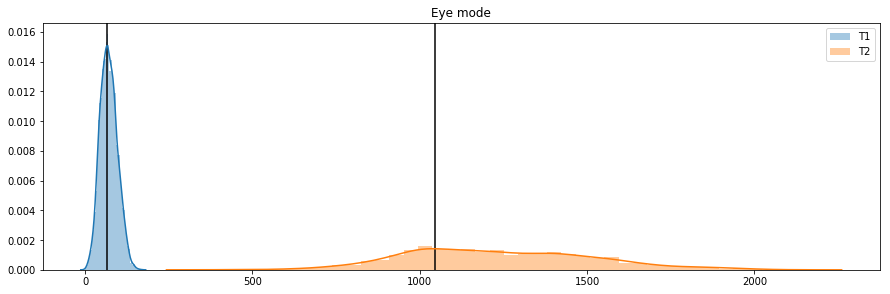

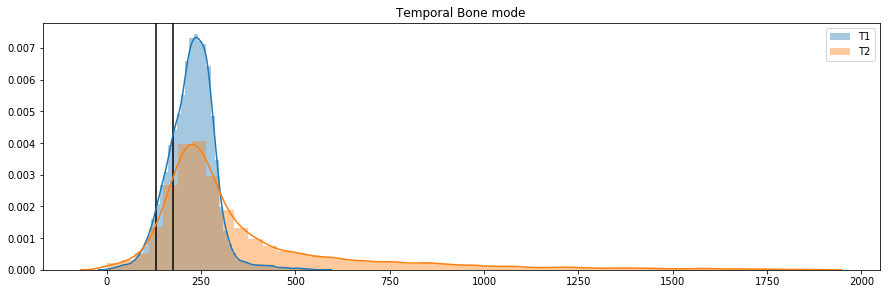

T1 eye: 65.4078598022461
T2 eye: 1044.296630859375
T1 temp: 131.23345947265625
T2 temp: 176.8667449951172


In [32]:
#Calibration stage
t1_bias_corr = nb.load('t1_bias_corr.nii.gz').get_data()
t2_bias_corr = nb.load('rigid_trans_t2_image_bias_corr.nii.gz').get_data()

eye_subj_mask = nb.load('eye_mask_subj.nii.gz').get_data().astype(bool)
temp_subj_mask = nb.load('temp_bone_mask_subj.nii.gz').get_data().astype(bool)

t1_subj_eye = stats.mode(t1_bias_corr[eye_subj_mask][t1_bias_corr[eye_subj_mask] > 0], axis = None)[0][0]
t1_subj_temp = stats.mode(t1_bias_corr[temp_subj_mask][t1_bias_corr[temp_subj_mask] > 0], axis = None)[0][0]
t2_subj_eye = stats.mode(t2_bias_corr[eye_subj_mask][t2_bias_corr[eye_subj_mask] > 0], axis = None)[0][0]
t2_subj_temp = stats.mode(t2_bias_corr[temp_subj_mask][t2_bias_corr[temp_subj_mask] > 0], axis = None)[0][0]

plot_mask_dist(t1_bias_corr, t2_bias_corr, eye_subj_mask, temp_subj_mask, 'mode')

In [33]:
brain_mask = nb.load('mni_icbm152_t1_tal_nlin_sym_09a_mask_subj.nii.gz').get_data().astype(bool)
t1_bias_corr[brain_mask].shape

(1239463,)

In [34]:
#Shorten linear equation for easier troubleshooting

t1_a = (t1_mni_temp - t1_mni_eye) / (t1_subj_temp - t1_subj_eye)
t1_b = ((t1_subj_temp * t1_mni_eye) - (t1_mni_temp * t1_subj_eye)) / (t1_subj_temp - t1_subj_eye)

t2_a = (t2_mni_temp - t2_mni_eye) / (t2_subj_temp - t2_subj_eye)
t2_b = ((t2_subj_temp * t2_mni_eye) - (t2_mni_temp * t2_subj_eye)) / (t2_subj_temp - t2_subj_eye)

In [42]:
#Intensity correction
t1_corr = (t1_a * t1_bias_corr[brain_mask]) + t1_b
t2_corr = (t2_a * t2_bias_corr[brain_mask]) + t2_b

# t1_corr = (t1_a * t1_bias_corr.ravel()) + t1_b
# t2_corr = (t2_a * t2_bias_corr.ravel()) + t2_b

print('{} {}'.format(t1_bias_corr.min(), t1_bias_corr.max()))
print('{} {}'.format(t2_bias_corr.min(), t2_bias_corr.max()))

print('{} {}'.format(t1_corr.min(), t1_corr.max()))
print('{} {}'.format(t2_corr.min(), t2_corr.max()))

0.0 2947.79931640625
0.0 3783.27685546875
1.6605719327926636 229.1571044921875
3.917288303375244 230.20896911621094


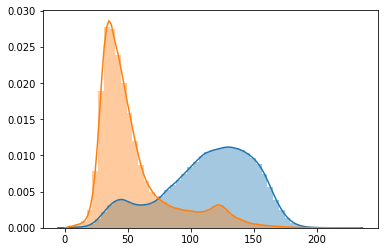

In [41]:
sns.distplot(t1_corr)
sns.distplot(t2_corr)

[2.86087394e-02 4.24632645e+01]
[0.3654662  5.72303667]


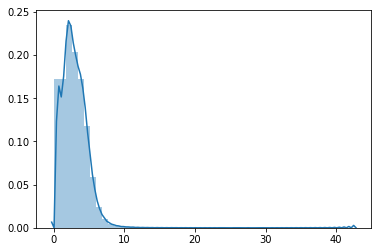

In [49]:
mm_arr = t1_corr / t2_corr
sns.distplot(mm_arr)
print(np.percentile(mm_arr, [0, 100]))
print(np.percentile(mm_arr, [5, 95]))

In [50]:
mm = np.zeros(brain_mask.shape)
mm[brain_mask] = mm_arr

In [51]:
fn = os.path.join(subj_dir,'t1t2.nii.gz')

im = nb.Nifti1Image(mm, affine = t1_hdr_subj.affine, header = t1_hdr_subj.header).to_filename(fn)

In [52]:
#Warp to MNI space

moving = fn
ref = t1_im_mni_fn
transmat = 'out_trans_InverseComposite.h5'

subj2mni = ants.ApplyTransforms()
subj2mni.inputs.dimension = 3
subj2mni.inputs.input_image = moving
subj2mni.inputs.reference_image = ref
subj2mni.inputs.transforms = transmat
subj2mni.inputs.output_image = os.path.join(subj_dir,'t1t2_mni.nii.gz')
subj2mni.inputs.interpolation = 'NearestNeighbor'
subj2mni.run()